In [1]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply

from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')
# pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import context_inference
from pyhf_pymc import one_line_inference
from pyhf_pymc import make_op

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import logging
logger = logging.getLogger('pymc')
logger.setLevel(logging.ERROR)

In [3]:
# blue = '#6495ed'
# orange = '#B47D49'

# blue = '#006994'
# orange = '#80396A'
#1F449C
blue = '#1F449C'
orange = '#E57A77'

green = '#006400'
lila = '#C875C4'

plt.rc('font', size=18)      
plt.rc('axes', titlesize=18)   
plt.rc('axes', labelsize=18)   
plt.rc('xtick', labelsize=18)   
plt.rc('ytick', labelsize=18)    
plt.rc('legend', fontsize=15)    
plt.rc('figure', titlesize=18)

plt.rcParams['font.family'] = 'DejaVu Sans'

## Model

In [4]:
nBins = 3
model = pyhf.simplemodels.correlated_background([10]*nBins,[50]*nBins,[55]*nBins,[45]*nBins)

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5.], [1.]]}
}

obs = model.expected_actualdata([0., 2.])

prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, priors=prior_dict)

In [5]:
obs

Array([70., 70., 70.], dtype=float64)

## Prior / Posterior Predictives

In [18]:

# with open('SRee_SRmm_Srem.json') as serialized:
with open('ttbar_ljets_xsec_inclusive_pruned.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
model = workspace.model()

obs = workspace.data(model, include_auxdata=False)

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

# Prepare the priors for sampling
    # Unconstrained parameters
unconstr_dict = {
    'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[2], [1]]}
    }

    # Create dictionary with all priors (unconstrained, constrained by normal and poisson)
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)

    # dictionary with keys 'model', 'obs', 'priors', 'precision'
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, priors=prior_dict)

In [19]:
with context_inference.pyhf_model(prepared_model):
    step = pm.Metropolis()
    post_data = pm.sample(draws=100, chains = 1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(100)



KeyboardInterrupt: 

In [ ]:
mean0 = prior_pred.prior_predictive.Expected_Data[0].T[0].mean()
mean1 = prior_pred.prior_predictive.Expected_Data[0].T[1].mean()
mean2 = prior_pred.prior_predictive.Expected_Data[0].T[2].mean()

post_mean0 = post_pred.posterior_predictive.Expected_Data[0].T[0].mean()
post_mean1 = post_pred.posterior_predictive.Expected_Data[0].T[1].mean()
post_mean2 = post_pred.posterior_predictive.Expected_Data[0].T[2].mean()

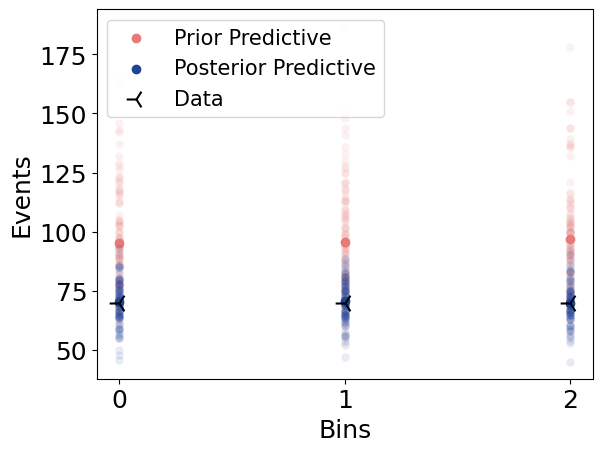

In [ ]:
plt.scatter(np.linspace(0,nBins-1,nBins), [mean0, mean1, mean2], color=orange, label='Prior Predictive')

plt.scatter(np.full(len(prior_pred.prior_predictive.Expected_Data[0].T[0]), 0), prior_pred.prior_predictive.Expected_Data[0].T[0], alpha=0.1, color=orange, linewidths=0)
plt.scatter(np.full(len(prior_pred.prior_predictive.Expected_Data[0].T[0]), 1), prior_pred.prior_predictive.Expected_Data[0].T[1], alpha=0.1, color=orange, linewidths=0)
plt.scatter(np.full(len(prior_pred.prior_predictive.Expected_Data[0].T[0]), 2), prior_pred.prior_predictive.Expected_Data[0].T[2], alpha=0.1, color=orange, linewidths=0)


plt.scatter(np.linspace(0,nBins-1,nBins), [post_mean0, post_mean1, post_mean2], color=blue, label='Posterior Predictive')

plt.scatter(np.full(len(prior_pred.prior_predictive.Expected_Data[0].T[0]), 0), post_pred.posterior_predictive.Expected_Data[0].T[0], alpha=0.1, color=blue, linewidths=0)
plt.scatter(np.full(len(prior_pred.prior_predictive.Expected_Data[0].T[0]), 1), post_pred.posterior_predictive.Expected_Data[0].T[1], alpha=0.1, color=blue, linewidths=0)
plt.scatter(np.full(len(prior_pred.prior_predictive.Expected_Data[0].T[0]), 2), post_pred.posterior_predictive.Expected_Data[0].T[2], alpha=0.1, color=blue, linewidths=0)

# Observations
plt.scatter(np.arange(nBins), obs, marker='3', c = 'k',s=200, zorder = 999, label = "Data")
plt.legend(loc='upper left')

plt.xticks([0, 1, 2])
plt.xlabel('Bins')
plt.ylabel('Events')

plt.savefig('final_plots/prior_posterior_events.pdf')


In [ ]:
# Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.Expected_Data[0].T, alpha = 0.035, c = orange, where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = orange , label='Prior Predictive');

# Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.Expected_Data[0].T, alpha = 0.035, c = blue, where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = blue, label='Posterior Predictive')

# Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=24, zorder = 999, label = "Data")
plt.legend(loc='upper left')
# plt.margins(x=0.015)

plt.title(f'Prior and Posterior Predictive ')
plt.xticks([0, 1, 2])
plt.xlabel('Bins')
plt.ylabel('Events')


plt.show()

## Corner Plots Prior / Posterior

In [ ]:
with context_inference.pyhf_model(prepared_model):
    step = pm.Metropolis()
    post_data = pm.sample(10_000, chains = 1, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(10_000)

Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 1 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


In [ ]:
my_range = [(-5, 5), (0, 16)]
my_bins = [25, 25]

a = corner.corner(prior_pred.prior, quantiles=[0.5], show_titles=True, title_fmt=None, color=orange, labels=['', ''], bins=my_bins, range=my_range)
corner.corner(post_data.posterior, quantiles=[0.5], color = blue, truths=[0., 2.], truth_color='grey', bins=[25, 25], fig=a, labels=['Correlated background', 'Signal strength'], range=my_range)
a.suptitle('Prior and Posterior Parameter Distributions')


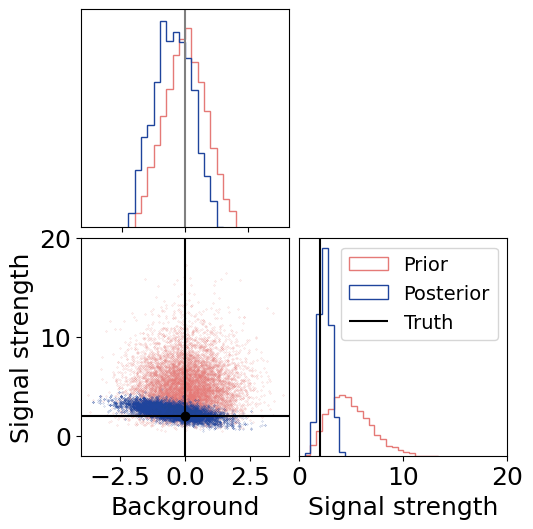

In [ ]:
yrange = (0, 13_000)

fig, axs = plt.subplots(2, 2, figsize=(5.5, 5.8))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
# fig.suptitle('Prior and Posterior Parameter Distributions')
axs[0, 1].remove()

ax1 = axs[0, 0]
ax2 = axs[1, 0]
ax3 = axs[1, 1]

# Normals Histogram
ax1.hist(prior_pred.prior.Normals[0], bins=30, histtype='step', color=orange)
_, bins, _ = ax1.hist(prior_pred.prior.Normals[0], bins=30, histtype='step', color=orange, alpha=0.000001)
ax1.hist(post_data.posterior.Normals[0], bins=bins, histtype='step', color=blue)
ax1.set_ylim(130)
ax1.vlines(0, 0, 13_000, color='grey')
ax1.set_yticks([])


# Scatter Plot
ax2.scatter(prior_pred.prior.Normals[0], prior_pred.prior.Unconstrained[0], alpha=0.6, s=0.04, color=orange)
ax2.scatter(post_data.posterior.Normals[0], post_data.posterior.Unconstrained[0], alpha=0.6, s=0.04, color=blue)
ax2.vlines(0, -2, 30, color='black')
ax2.set_ylim(-2, 20)
ax2.hlines(2, -6, 6, color='black')
ax2.set_xlim(-4, 4)
ax2.scatter(0, 2, color='black')
ax2.set_xlabel('Background')
ax2.set_ylabel('Signal strength')

# Unconstrained Histogram
ax3.hist(prior_pred.prior.Unconstrained[0], bins=30, histtype='step', color=orange, label='Prior')
_, bins, _ = ax3.hist(prior_pred.prior.Unconstrained[0], bins=30, histtype='step', color=orange, alpha=0.000001)
ax3.hist(post_data.posterior.Unconstrained[0], bins=bins, histtype='step', color=blue, label='Posterior')
ax3.set_yticks([])
ax3.set_xticks([0, 10, 20])
ax3.set_ylim(30)
ax3.set_xlim(0)
ax3.vlines(2, 0, 13_000, color='black', label='Truth')
ax3.set_xlabel('Signal strength')
plt.rc('legend', fontsize=14)  
ax3.legend()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

  

## Calibration Posterior Distribution

In [6]:
expData_op = make_op.make_op(prepared_model)

In [9]:
def prior_pars_data(n_samples):
        with pm.Model() as m:
                pars = prepare_inference.priors2pymc(prepared_model)

                Expected_Data = pm.Poisson("Expected_Data", mu=expData_op(pars))
                
                prior_pred = pm.sample_prior_predictive(n_samples)

        return np.array(prior_pred.prior.Normals[0]), np.array(prior_pred.prior.Unconstrained[0]), np.array(prior_pred.prior_predictive.Expected_Data[0])

def posterior_from_prior(prior_data):
        n_samples = len(np.array(prior_pred.prior_predictive.Expected_Data[0]))
        with pm.Model() as m:
                pars = prepare_inference.priors2pymc(prepared_model)

                
                Expected_Data = pm.Poisson("Expected_Data", mu=expData_op(pars), observed=prior_data)
                
                step1 = pm.Metropolis()
                post_data = pm.sample(n_samples, chains=1, step=step1)
                post_pred = pm.sample_posterior_predictive(post_data)

        return np.array(post_data.posterior.Normals[0]), np.array(post_data.posterior.Unconstrained[0]), np.array(post_pred.posterior_predictive.Expected_Data[0][0])
        

In [10]:
prior_Normals, prior_Unconstrained, prior_data = prior_pars_data(3)

AttributeError: 'dict' object has no attribute 'expected_actualdata'
Apply node that caused the error: ExpDataOp(MakeVector{dtype='float64'}.0)
Toposort index: 5
Inputs types: [TensorType(float64, (2,))]
Inputs shapes: [(2,)]
Inputs strides: [(8,)]
Inputs values: [array([-4.62727122e-03,  6.22846925e+00])]
Outputs clients: [[poisson_rv{0, (0,), int64, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2CC749120>), TensorConstant{[]}, TensorConstant{4}, ExpDataOp.0)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell
    result = self._run_cell(
  File "/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell
    return runner(coro)
  File "/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/p9/sw_pjm3j027cxfs57s_91bfw0000gn/T/ipykernel_4423/3139989689.py", line 1, in <module>
    prior_Normals, prior_Unconstrained, prior_data = prior_pars_data(3)
  File "/var/folders/p9/sw_pjm3j027cxfs57s_91bfw0000gn/T/ipykernel_4423/3911387153.py", line 5, in prior_pars_data
    Expected_Data = pm.Poisson("Expected_Data", mu=expData_op(pars))

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [12]:
post_n, post_u, post_d = [], [], []
count = 0
for p_d in prior_data:
    count += 1
    print(f'STEP:  {count}')
    a, b, c = posterior_from_prior(p_d, 1)
    post_n.append(a)
    post_u.append(b)
    post_d.append(c)

STEP:  428


STEP:  429


STEP:  430


STEP:  431


STEP:  432


STEP:  433


STEP:  434


STEP:  435


STEP:  436


STEP:  437


STEP:  438


STEP:  439


STEP:  440


STEP:  441


STEP:  442


STEP:  443


STEP:  444


STEP:  445


STEP:  446


STEP:  447


STEP:  448


STEP:  449


STEP:  450


STEP:  451


STEP:  452


STEP:  453


STEP:  454


STEP:  455


STEP:  456


STEP:  457


STEP:  458


STEP:  459


STEP:  460


STEP:  461


STEP:  462


STEP:  463


STEP:  464


STEP:  465


STEP:  466


STEP:  467


STEP:  468


STEP:  469


STEP:  470


STEP:  471


STEP:  472


STEP:  473


STEP:  474


STEP:  475


STEP:  476


STEP:  477


STEP:  478


STEP:  479


STEP:  480


STEP:  481


STEP:  482


STEP:  483


STEP:  484


STEP:  485


STEP:  486


STEP:  487


STEP:  488


STEP:  489


STEP:  490


STEP:  491


STEP:  492


STEP:  493


STEP:  494


STEP:  495


STEP:  496


STEP:  497


STEP:  498


STEP:  499


STEP:  500


STEP:  501


STEP:  502


STEP:  503


STEP:  504


STEP:  505


STEP:  506


STEP:  507


STEP:  508


STEP:  509


STEP:  510


STEP:  511


STEP:  512


STEP:  513


STEP:  514


STEP:  515


STEP:  516


STEP:  517


STEP:  518


STEP:  519


STEP:  520


STEP:  521


STEP:  522


STEP:  523


STEP:  524


STEP:  525


STEP:  526


STEP:  527


STEP:  528


STEP:  529


STEP:  530


STEP:  531


STEP:  532


STEP:  533


STEP:  534


STEP:  535


STEP:  536


STEP:  537


STEP:  538


STEP:  539


STEP:  540


STEP:  541


STEP:  542


STEP:  543


STEP:  544


STEP:  545


STEP:  546


STEP:  547


STEP:  548


STEP:  549


STEP:  550


STEP:  551


STEP:  552


STEP:  553


STEP:  554


STEP:  555


STEP:  556


STEP:  557


STEP:  558


STEP:  559


STEP:  560


STEP:  561


STEP:  562


STEP:  563


STEP:  564


STEP:  565


STEP:  566


STEP:  567


STEP:  568


STEP:  569


KeyboardInterrupt: 

In [13]:
post_Normals, post_Unconstrained, post_data = [], [], []
for a in post_n:
    post_Normals.append(a)
post_Normals = np.concatenate(post_Normals)

for b in post_u:
    post_Unconstrained.append(b)
post_Unconstrained = np.concatenate(post_Unconstrained)

for c in post_d:
    post_data.append(c)
post_data = np.concatenate(post_data)

In [42]:
with open('post_Normals_Metropolis.txt', 'w') as filehandle:
    json.dump(post_Normals.tolist(), filehandle)
with open('post_Unconstrained_Metropolis.txt', 'w') as filehandle:
    json.dump(post_Unconstrained.tolist(), filehandle)

with open('prior_Normals_Metropolis.txt', 'w') as filehandle:
    json.dump(post_Normals.tolist(), filehandle)
with open('prior_Unconstrained_Metropolis.txt', 'w') as filehandle:
    json.dump(post_Unconstrained.tolist(), filehandle)

In [29]:
from numpy import loadtxt

#read text file into NumPy array
post_Normals = loadtxt('post_Normals_Metropolis.txt', dtype=object)
prior_Normals = loadtxt('prior_Normals_Metropolis.txt', dtype=object)

In [34]:
post_Normals = np.concatenate(post_Normals)
prior_Normals = np.concatenate(prior_Normals)

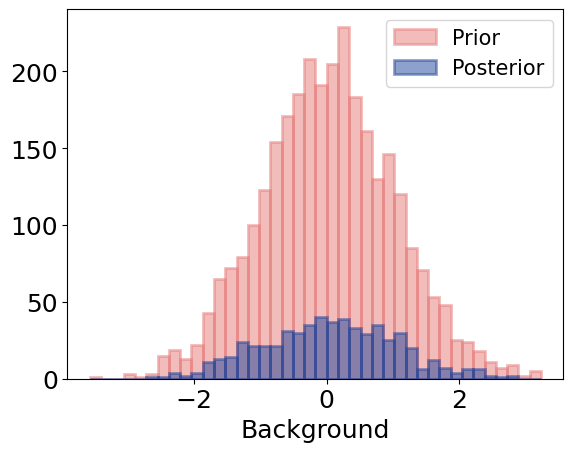

In [14]:
plt.hist(prior_Normals, 40, alpha = 0.5, color=orange, linewidth=2, label='Prior', edgecolor=orange)
_, bins, _ = plt.hist(prior_Normals, bins=40, histtype='step', color=orange, alpha=0.000001)
plt.hist(post_Normals, bins=bins, alpha = 0.5, color=blue, linewidth=2, label='Posterior', edgecolor=blue)
plt.xlabel('Background')

plt.legend()

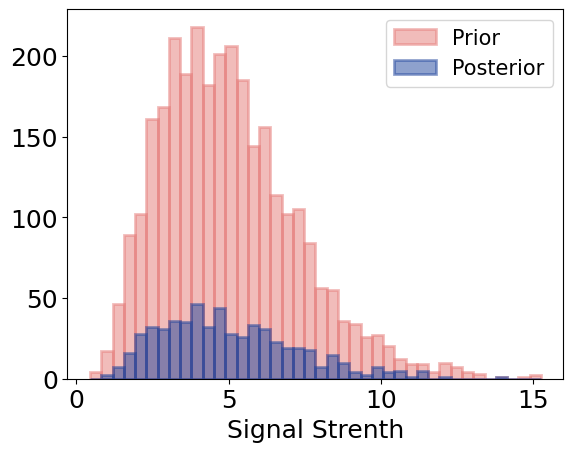

In [15]:
plt.hist(prior_Unconstrained, 40, alpha = 0.5, color=orange, linewidth=2, label='Prior', edgecolor=orange)
_, bins, _ = plt.hist(prior_Unconstrained, bins=40, histtype='step', color=orange, alpha=0.000001)
plt.hist(post_Unconstrained, bins=bins, alpha = 0.5, color=blue, linewidth=2, label='Posterior', edgecolor=blue)
plt.xlabel('Signal Strenth')

plt.legend()

In [16]:
prior_data

array([[ 80,  92,  98],
       [114,  87,  97],
       [101, 106, 106],
       ...,
       [ 78,  95,  67],
       [ 74,  75,  90],
       [113,  99, 126]])

## Autocorrelation

In [ ]:
with context_inference.pyhf_model(prepared_model):
    step = pm.Metropolis()
    post_data_MH = pm.sample(100, chains = 1, step=step)

with context_inference.pyhf_model(prepared_model):
    step = pm.Metropolis()
    post_data_MH_thinned = pm.sample(1200, chains = 1, step=step)

Only 100 samples in chain.


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 0 seconds.
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (100) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


Sampling 1 chain for 1_000 tune and 1_200 draw iterations (1_000 + 1_200 draws total) took 0 seconds.
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (1200) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [ ]:
with context_inference.pyhf_model(prepared_model):
    post_data_NUTS = pm.sample(100, chains = 1)

with context_inference.pyhf_model(prepared_model):
    post_data_NUTS_thinned = pm.sample(600, chains = 1)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 100 draw iterations (1_000 + 100 draws total) took 1 seconds.
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (100) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Sampling 1 chain for 1_000 tune and 600 draw iterations (1_000 + 600 draws total) took 1 seconds.
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (600) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


In [ ]:
thinned_MH = post_data_MH_thinned.posterior.thin(12)
thinned_NUTS = post_data_NUTS_thinned.posterior.thin(6)

In [ ]:
# Metropolis
post_Normals_MH = np.concatenate(np.array(post_data_MH.posterior.Normals[0]))
post_Unconstrained_MH = np.concatenate(np.array(post_data_MH.posterior.Unconstrained[0]))

post_Normals_MH_thinned = np.concatenate(np.array(thinned_MH.Normals[0]))
post_Unconstrained_MH_thinned = np.concatenate(np.array(thinned_MH.Unconstrained[0]))

# NUTS
post_Normals_NUTS = np.concatenate(np.array(post_data_NUTS.posterior.Normals[0]))
post_Unconstrained_NUTS = np.concatenate(np.array(post_data_NUTS.posterior.Unconstrained[0]))

post_Normals_NUTS_thinned = np.concatenate(np.array(thinned_NUTS.Normals[0]))
post_Unconstrained_NUTS_thinned = np.concatenate(np.array(thinned_NUTS.Unconstrained[0]))

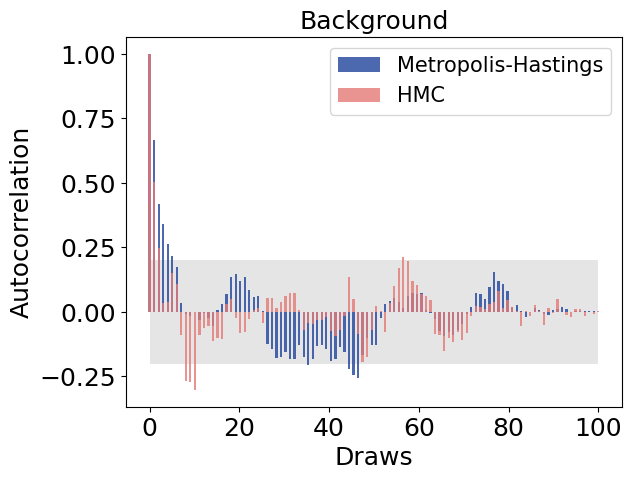

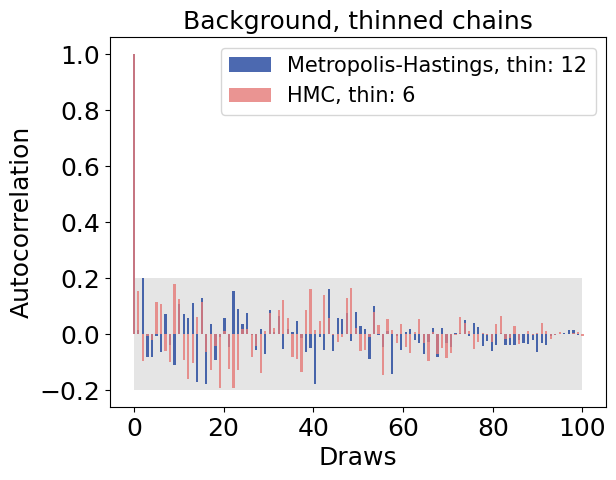

In [ ]:
fig = plt.bar(np.linspace(0, 100, 100), az.autocorr(post_Normals_MH), width=0.5, alpha=0.8, color=blue, label='Metropolis-Hastings')
plt.bar(np.linspace(0, 100, 100), az.autocorr(post_Normals_NUTS), width=0.5, alpha=0.8, color=orange, label='HMC')
plt.fill_between(np.linspace(0, 100, 100), -0.2, 0.2, color='grey', alpha=0.2, zorder=0, linewidth=0)
plt.xlabel('Draws')
plt.ylabel('Autocorrelation')
plt.legend()
plt.title('Background')
plt.show()


plt.bar(np.linspace(0, 100, 100), az.autocorr(post_Normals_MH_thinned), width=0.5, alpha=0.8, color=blue, label='Metropolis-Hastings, thin: 12')
plt.bar(np.linspace(0, 100, 100), az.autocorr(post_Normals_NUTS_thinned), width=0.5, alpha=0.8, color=orange, label='HMC, thin: 6')
plt.fill_between(np.linspace(0, 100, 100), -0.2, 0.2, color='grey', alpha=0.2, zorder=0, linewidth=0)
plt.xlabel('Draws')
plt.ylabel('Autocorrelation')
plt.legend()
plt.title('Background, thinned chains');

In [ ]:
plt.bar(np.linspace(0, 100, 100), az.autocorr(post_Unconstrained_MH), width=0.5, alpha=0.8, color=green, label='Metropolis-Hastings')
plt.bar(np.linspace(0, 100, 100), az.autocorr(post_Unconstrained_NUTS), width=0.5, alpha=0.8, color=lila, label='HMC (NUTS)')
plt.fill_between(np.linspace(0, 100, 100), -0.2, 0.2, color='grey', alpha=0.2, zorder=0, linewidth=0)
plt.legend()
plt.title('Autocorrelation for the signal strength')
plt.show()


plt.bar(np.linspace(0, 100, 100), az.autocorr(post_Unconstrained_MH_thinned), width=0.5, alpha=0.8, color=green, label='Metropolis-Hastings, thin: 12')
plt.bar(np.linspace(0, 100, 100), az.autocorr(post_Unconstrained_NUTS_thinned), width=0.5, alpha=0.8, color=lila, label='HMC (NUTS), thin: 6')
plt.fill_between(np.linspace(0, 100, 100), -0.2, 0.2, color='grey', alpha=0.2, zorder=0, linewidth=0)
plt.legend()
plt.title('Autocorrelation for the signal strength, thinned chains')